To allow inline pictures, run the following block

In [1]:
%matplotlib inline

Import the useful libraries

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import math
colors = ['red', 'green', 'blue', 'purple', 'slategrey', 'brown', 'darkorange', 'black']

Data to read

In [3]:
dataPath = '../Generator'
dataFile = 'JC-Experiments.xlsx'

To be sure that the **Experiments.xlsx** file is in the current directory, run the following block by clicking CTRL+ENTER

In [4]:
import os
print("List of files of directory:", os.path.abspath(os.getcwd()+'/'+dataPath))
os.listdir(os.getcwd()+'/'+dataPath)

List of files of directory: /home/pantale/SynologyDrive/Programming/Python/ANN-ConstitutiveLaw/Generator


['OriginalData100.svg',
 'OriginalData20.svg',
 'OriginalData300.svg',
 'OriginalData500.svg',
 'JC-Experiments.xlsx',
 'OriginalData200.svg',
 '.ipynb_checkpoints',
 'Johnson-Cook.ipynb']

Read the content of the Excel file using the pandas library method read_excel.

In [5]:
excelData = pd.read_excel(dataPath+'/'+dataFile, None)

Extract list of temperatures from the name of sheets

In [6]:
len(excelData)
temperatures = []
temps = list(excelData.keys())
for T in temps:
    temperatures.append(int(T.replace('°C','')))
temperatures

[20, 100, 200, 300, 500]

Get the values of epsp

In [7]:
dataSheet = excelData[str(temperatures[0])+'°C']
epsp = []
for i in range(1, dataSheet.shape[1]):
    epsp.append(dataSheet.columns[i])
epspOrig = epsp
epsp

[0.1, 1, 50, 1000, 500000]

Extract data from the panda sheets

In [8]:
# Read first sheet
dataSheet = excelData[str(temperatures[0])+'°C']
data = dataSheet.values
eps = data[:,0]
sig = data[:,1:]
# Append the other sheets
for T in temperatures[1:]:
    dataSheet = excelData[str(T)+'°C']
    data = dataSheet.values
    sig = np.append(sig, data[:,1:], axis=1)

In [9]:
temperatures = np.array(temperatures)
epsp = np.log(np.array(epsp)/0.1)
epspArray = np.tile(epsp,temperatures.shape[0])
temperaturesArray = temperatures.repeat(epsp.shape[0])
epspArray, temperaturesArray

(array([ 0.        ,  2.30258509,  6.2146081 ,  9.21034037, 15.42494847,
         0.        ,  2.30258509,  6.2146081 ,  9.21034037, 15.42494847,
         0.        ,  2.30258509,  6.2146081 ,  9.21034037, 15.42494847,
         0.        ,  2.30258509,  6.2146081 ,  9.21034037, 15.42494847,
         0.        ,  2.30258509,  6.2146081 ,  9.21034037, 15.42494847]),
 array([ 20,  20,  20,  20,  20, 100, 100, 100, 100, 100, 200, 200, 200,
        200, 200, 300, 300, 300, 300, 300, 500, 500, 500, 500, 500]))

In [10]:
entries = np.empty([epspArray.shape[0]*eps.shape[0], 4])
row = 0
colEps = 0
colEpsp = 1
colT = 2
colSig = 3
for i in range(epspArray.shape[0]):
    for j in range(eps.shape[0]):
        entries[row, colEps] = eps[j]
        entries[row, colEpsp] = epspArray[i]
        entries[row, colT] = temperaturesArray[i]
        entries[row, colSig] = sig[j,i]
        row += 1
entries

array([[0.00000000e+00, 0.00000000e+00, 2.00000000e+01, 8.06000000e+02],
       [2.04081633e-02, 0.00000000e+00, 2.00000000e+01, 1.12531214e+03],
       [4.08163265e-02, 0.00000000e+00, 2.00000000e+01, 1.16474716e+03],
       ...,
       [9.59183673e-01, 1.54249485e+01, 5.00000000e+02, 1.15698156e+03],
       [9.79591837e-01, 1.54249485e+01, 5.00000000e+02, 1.15874710e+03],
       [1.00000000e+00, 1.54249485e+01, 5.00000000e+02, 1.16048230e+03]])

In [11]:
maxEntries = entries.max(axis=0)

In [12]:
NNentries = entries / np.array(maxEntries)
NNentries

array([[0.        , 0.        , 0.04      , 0.4990896 ],
       [0.02040816, 0.        , 0.04      , 0.69681338],
       [0.04081633, 0.        , 0.04      , 0.72123224],
       ...,
       [0.95918367, 1.        , 1.        , 0.71642365],
       [0.97959184, 1.        , 1.        , 0.7175169 ],
       [1.        , 1.        , 1.        , 0.71859137]])

In [13]:
np.save('Entries.npy', entries)
np.save('NN-Entries.npy', NNentries)

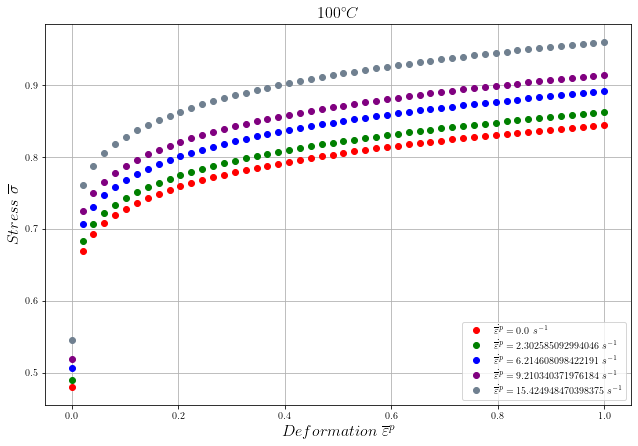

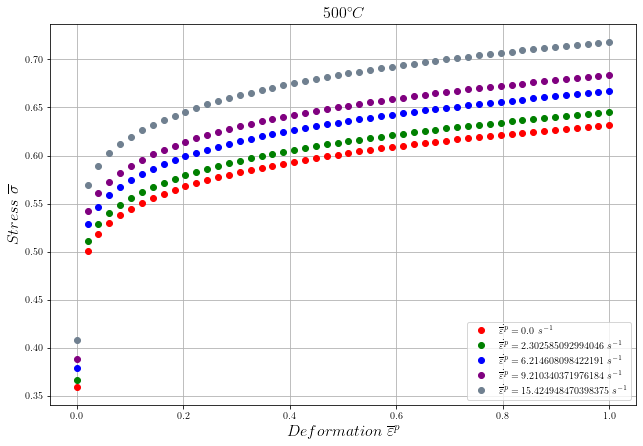

In [14]:
for T in temperatures:
    plt.figure(figsize = (10.5, 7))
    plt.rc('text', usetex = True)
    cl = 0
    for epspv in epsp:
        # filter on T
        data = NNentries[(entries[:,colT]==T) & (entries[:,colEpsp]==epspv), :]
        # Plot the curves
        plt.plot(data[:,colEps], data[:,colSig], colors[cl], label=r'$\dot{\overline{\varepsilon}^p}=' + str(epspv) + '\ s^{-1}$', marker = 'o', linestyle='none')
        cl += 1
    plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 10)
    plt.grid() # Plot the grid with default size
    plt.xlabel(r'$Deformation\ \overline{\varepsilon}^{p}$', fontsize = 16) # Labels the x axis
    plt.ylabel(r'$Stress\ \overline{\sigma}$', fontsize = 16) # Labels the y axis
    plt.title(r'$' + str(T) + '^{\circ}C$', fontsize = 16) # Self explicit command
    plt.savefig('OriginalData'+str(T)+'.svg', bbox_inches = 'tight', pad_inches = 0)
    plt.show()

## Mise en forme des données pour le RNN

In [15]:
T = 20
#epspv = 0.1
#data = NNentries[(entries[:,colT]==T) & (entries[:,colEpsp]==epspv), :]
data = NNentries[(entries[:,colT]==T), :]
NNinput = data[:,0:2]#.reshape(250,2)
NNoutput = data[:,colSig]#.reshape(250,1)
NNinput, NNoutput

(array([[0.        , 0.        ],
        [0.02040816, 0.        ],
        [0.04081633, 0.        ],
        [0.06122449, 0.        ],
        [0.08163265, 0.        ],
        [0.10204082, 0.        ],
        [0.12244898, 0.        ],
        [0.14285714, 0.        ],
        [0.16326531, 0.        ],
        [0.18367347, 0.        ],
        [0.20408163, 0.        ],
        [0.2244898 , 0.        ],
        [0.24489796, 0.        ],
        [0.26530612, 0.        ],
        [0.28571429, 0.        ],
        [0.30612245, 0.        ],
        [0.32653061, 0.        ],
        [0.34693878, 0.        ],
        [0.36734694, 0.        ],
        [0.3877551 , 0.        ],
        [0.40816327, 0.        ],
        [0.42857143, 0.        ],
        [0.44897959, 0.        ],
        [0.46938776, 0.        ],
        [0.48979592, 0.        ],
        [0.51020408, 0.        ],
        [0.53061224, 0.        ],
        [0.55102041, 0.        ],
        [0.57142857, 0.        ],
        [0.591

Construction du Réseau de Neurones

In [16]:
# Importation de TensorFlow 
import numpy as np
from keras.models import Sequential
from keras.metrics import MeanSquaredError
from keras.layers.core import Dense, Activation
from keras import optimizers

In [17]:
#Création du modèle
model=Sequential()
#model.add(Dense(3, input_dim=2, activation='sigmoid'))
#model.add(Dense(6, input_dim=2, activation='tanh'))
model.add(Dense(6, input_dim=2, activation='relu'))
model.add(Dense(2, activation='tanh'))
#model.add(Activation(activation='tanh'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 18        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 14        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [18]:
#sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='mean_squared_error', optimizer=sgd, metrics=[MeanSquaredError()])

In [19]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='mse', optimizer='adams', metrics=[MeanSquaredError()])

In [20]:
hist = []

In [25]:
epochs = 50
for i in range(epochs):
    #print("Epoch :", i+1, "/",epochs)
    history=model.fit(NNinput, NNoutput, epochs=100, verbose=0)
    #history=model.fit(NNinput, NNoutput, epochs=1, verbose=0)
    loss = history.history['loss'][-1]
    hist.append(loss)
    print("Epoch :", i+1, "/",epochs,"->",loss,"         ", end='\r')

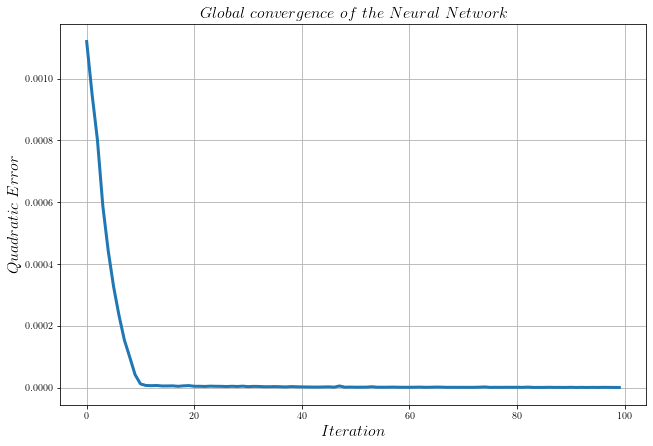

In [26]:
plt.figure(figsize = (10.5, 7))
plt.rc('text', usetex = True)
plt.plot(hist, linewidth=3)
plt.grid() # Plot the grid with default size
plt.xlabel(r'$Iteration$', fontsize = 16) # Labels the x axis
plt.ylabel(r'$Quadratic\ Error\ $', fontsize = 16) # Labels the y axis
plt.title(r'$Global\ convergence\ of\ the\ Neural\ Network$', fontsize = 16) # Self explicit command
plt.show()

In [29]:
predictedOutput = model.predict(NNinput)
plotPredicted=predictedOutput.reshape(5,50).T
#plotPredicted

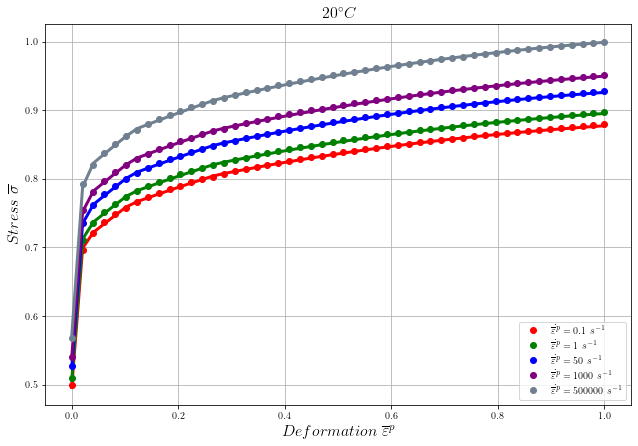

In [28]:
plt.figure(figsize = (10.5, 7))
plt.rc('text', usetex = True)
cl = 0
for epspv, epspvAff in zip(epsp,epspOrig):
    # filter on T
    data = NNentries[(entries[:,colT]==T) & (entries[:,colEpsp]==epspv), :]
    # Plot the curves
    plt.plot(data[:,colEps], data[:,colSig], colors[cl], label=r'$\dot{\overline{\varepsilon}^p}=' + str(epspvAff) + '\ s^{-1}$', marker = 'o', linestyle='none')
    plt.plot(data[:,colEps], plotPredicted[:,cl], colors[cl], linewidth = 3)
    cl += 1
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 10)
plt.grid() # Plot the grid with default size
plt.xlabel(r'$Deformation\ \overline{\varepsilon}^{p}$', fontsize = 16) # Labels the x axis
plt.ylabel(r'$Stress\ \overline{\sigma}$', fontsize = 16) # Labels the y axis
plt.title(r'$' + str(T) + '^{\circ}C$', fontsize = 16) # Self explicit command
plt.savefig('OriginalData'+str(T)+'.svg', bbox_inches = 'tight', pad_inches = 0)
plt.show()